In [1]:
import tensorflow as tf
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# Preprocessing:

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
dax = pd.read_csv('DAX.csv',parse_dates=['Date'], date_parser=dateparse) # read in raw data
dax = dax[dax.Close != 'null'] # delete 'null' holidays
dax[dax.columns[1:7]] =  dax[dax.columns[1:7]].astype(float) # convert index prices to floats
print "Data Format: ", dax.columns.get_values()


Data Format:  ['Date' 'Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume']


# Data Analysis:

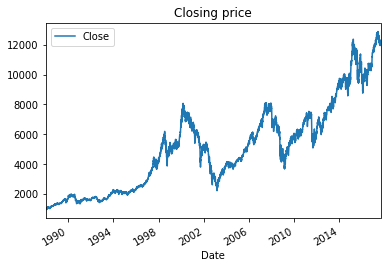

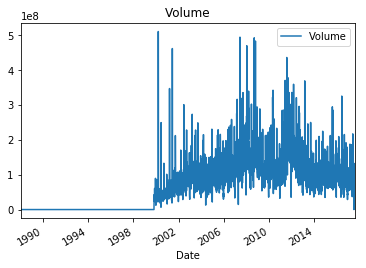

In [3]:
dax.plot(x='Date',y='Close',title='Closing price')
dax.plot(x='Date',y='Volume',title='Volume')

## Volantility:

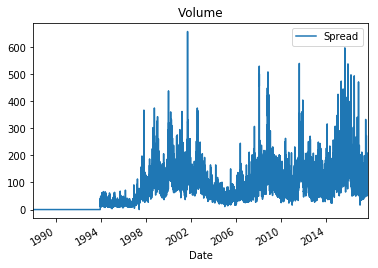

In [4]:
dax['Spread'] = abs(dax['High'] - dax['Low'])
dax.plot(x='Date',y='Spread',title='Volume')

## Gap Closures:

In [5]:
gap_data = pd.DataFrame()



for i in range(dax.shape[0]):
    if dax.iloc[i,2] != dax.iloc[i,3]:
        #print i
        break
gap_data = dax.iloc[1489:,:]

def f(min_points):
    gap_closed = []
    for i in range(1,gap_data.shape[0]):
        last_closing = gap_data.iloc[i-1,4]
        opening = gap_data.iloc[i,1]
        high = gap_data.iloc[i,2]
        low = gap_data.iloc[i,3]
        gap_size = abs(opening-last_closing)
        if opening > last_closing: # if opening price is larger than last closing price
            if low <= last_closing and gap_size > min_points : # if gap has been closed from the top
                gap_closed.append(1)
            else:
                gap_closed.append(0)
        else:
            if high >= gap_data.iloc[i-1,4] and gap_size > min_points: # if gap has been closed from below
                gap_closed.append(1)
            else:
                gap_closed.append(0)


    gap_closed = np.asarray(gap_closed)

    total_elems = gap_closed.shape[0]
    print "Gap closed %: " , float(np.count_nonzero(gap_closed))/float(total_elems)
    print "Gap not closed %: ", float(np.count_nonzero(gap_closed==0))/float(total_elems)

    gap_closed_filtered = np.convolve(gap_closed, np.ones((100,))/100, mode='valid')
    plt.plot(gap_closed_filtered)
    plt.title('Gap closures over time')
    plt.show


In [6]:
interact(f, min_points=(0,20));

A Jupyter Widget

Avrg points in gap direction:  44.0768150665


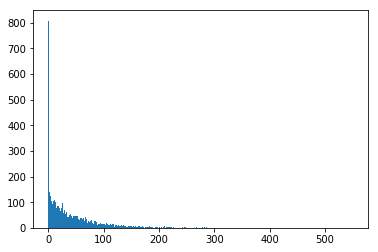

In [7]:

points_in_gap_dir = []
for i in range(1,gap_data.shape[0]):
    last_closing = gap_data.iloc[i-1,4]
    opening = gap_data.iloc[i,1]
    high = gap_data.iloc[i,2]
    low = gap_data.iloc[i,3]
    gap_size = abs(opening-last_closing)
    if opening > last_closing: # if opening price is larger than last closing price
        if low < opening : # if gap has been closed from the top
            points_in_gap_dir.append(abs(low-opening))
        else:
            points_in_gap_dir.append(0)
    else:
        if high > opening: # if gap has been closed from below
            points_in_gap_dir.append(abs(high-opening))
        else:
            points_in_gap_dir.append(0)


points_in_gap_dir = np.asarray(points_in_gap_dir)
plt.hist(points_in_gap_dir,500)
plt.show

total_elems = points_in_gap_dir.shape[0]
print "Avrg points in gap direction: " , float(sum(points_in_gap_dir))/float(total_elems)

#filter = 10
#gap_closed_filtered = np.convolve(points_in_gap_dir, np.ones((filter,))/filter, mode='valid')
#plt.plot(gap_closed_filtered)
#plt.title('Points in gap direction')
#plt.show

# Let the deep learning magic happend

In [8]:
import tensorflow as tf
dax['Date'] = pd.to_datetime(dax['Date'])
dax =  dax.set_index('Date')

In [9]:
#train_data = pd.DataFrame()
#test_data = pd.DataFrame()

volume_start = -1
for i in range(dax.shape[0]):
    if dax.iloc[i,6] != 0:
        volume_start = i
        break
print "Volume data starts at", dax.index[volume_start]

#print type(dax.iloc[volume_start,:])

train_data = dax['1994-01-01':'2016-12-31']
test_data = dax['2017-01-01':]

#print type(train_data)

print "We have", train_data.shape[0], "train data and", test_data.shape[0], "test data. That makes up a ratio of", float(train_data.shape[0])/float(test_data.shape[0]), ":1"






Volume data starts at 1993-12-14 00:00:00
We have 5826 train data and 176 test data. That makes up a ratio of 33.1022727273 :1


In [39]:
def sample_batch(batch_size, feature_length):
    rand_idx = np.random.randint(feature_length,5826, size=batch_size) # these are the indizes of the values we want to predict
    labels = train_data.iloc[rand_idx,3] # closing prices to predict
    
    features = [train_data.iloc[rand_idx[i]-feature_length:rand_idx[i],[0,1,2,3,5]].values for i in range(batch_size)]
    
    return features, labels
    
def make_regression_network():
    features = tf.placeholder(tf.float32, shape=(None, 25))
    hidden1 = tf.layers.dense(features,1000,tf.nn.elu)
    hidden2 = tf.layers.dense(hidden1,1000,tf.nn.elu)
    prediction = tf.layers.dense(hidden2,1,activation=None)
    
    label = tf.placeholder(tf.float32, shape=(None, 25))
    loss = tf.reduce_mean(tf.square(prediction-label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    optimize = optimizer.minimize(loss)
    return features, label, loss, optimize

In [40]:
features, labels = sample_batch(32,5)
print len(features)

32


In [46]:
training_steps = 1000
feature_pl, label_pl, loss, optimize = make_regression_network()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(training_steps):
    print i
    features, labels = sample_batch(32,5)
    features = np.reshape(features,(32,25))
    print 
    sess.run([optimize,loss], feed_dict={feature_pl:features, label_pl:labels})
 

0



ValueError: Cannot feed value of shape (32,) for Tensor u'Placeholder_26:0', which has shape '(?, 25)'